In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from neuralforecast.utils import AirPassengersDF as df
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchmetrics import MeanSquaredError, RootMeanSquaredErrorUsingSlidingWindow

# jupyter notebook --NotebookApp.iopub_msg_rate_limit=50000

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class TSRegressionDataset(Dataset):
    def __init__(self, df, in_features, out_features, window=1):
        super(TSRegressionDataset, self).__init__()

        self.data = df
        self.in_features = in_features
        self.out_features = out_features
        self.window = window

        self.groups = {uid: group.reset_index(drop=True) for uid, group in df.groupby("unique_id")}

    def __len__(self):

        return sum(
            [
                (len(g) - (self.in_features + self.out_features)) // self.window + 1
                for g in self.groups.values()
            ]
        )

    def __getitem__(self, idx):

        for uid, df in self.groups.items():
            max_idx = (len(df) - (self.in_features + self.out_features)) // self.window + 1

            if idx < max_idx:
                start = idx * self.window
                x = torch.tensor(
                    df["y"].iloc[start : start + self.in_features].values, dtype=torch.float32
                )
                y = torch.tensor(
                    df["y"]
                    .iloc[start + self.in_features : start + self.in_features + self.out_features]
                    .values,
                    dtype=torch.float32,
                )
                return x, y

            idx -= max_idx

In [ ]:
class TSDataLoader(pl.LightningDataModule):
    def __init__(self, df, in_features, out_features, window=1, batch_size=32):
        super(TSDataLoader, self).__init__()
        self.data = df
        self.in_features = in_features
        self.out_features = out_features
        self.window = window
        self.batch_size = batch_size

    def setup(self, stage=None):
        assert list(self.data.columns) == [
            "unique_id",
            "ds",
            "y",
        ], "Columns must be ['unique_id', 'ds', 'y']"

        self.data = self.data.sort_values(["unique_id", "ds"])

        # Train / Val / Test Split (70/15/15)
        train_sz = int(len(self.data) * 0.7)
        val_sz = int(len(self.data) * 0.15)

        self.train_df = self.data.iloc[:train_sz]
        self.val_df = self.data.iloc[train_sz : train_sz + val_sz]
        self.test_df = self.data.iloc[train_sz + val_sz :]

        self.train = TSRegressionDataset(
            self.train_df, self.in_features, self.out_features, self.window
        )
        self.val = TSRegressionDataset(
            self.val_df, self.in_features, self.out_features, self.window
        )
        self.test = TSRegressionDataset(
            self.test_df, self.in_features, self.out_features, self.window
        )

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, pin_memory=True)

In [ ]:
class MLP(pl.LightningModule):
    def __init__(self, input_sz, no_of_layers, hidden_sz, output_sz, lr=1e-3):
        super().__init__()
        # self.save_hyperparameters()

        layers = [nn.Linear(in_features=input_sz, out_features=hidden_sz), nn.ReLU()]
        for _ in range(no_of_layers):
            layers.append(nn.Linear(in_features=hidden_sz, out_features=hidden_sz))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(in_features=hidden_sz, out_features=output_sz))
        self.model = nn.Sequential(*layers)

        self.loss = nn.HuberLoss()
        # self.loss = nn.MSELoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        self.log("test_loss", loss, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

In [ ]:
## Usage

In [ ]:
## Hyper Parameters
in_features, out_features, window, batch_sz = 14, 5, 3, 32 * 8
layers = 9
hidden_sz = 32

In [ ]:
ds = TSDataLoader(df, in_features, out_features, window, batch_sz)
model = MLP(in_features, layers, hidden_sz, out_features).to(device)
trainer = pl.Trainer(max_epochs=100, val_check_interval=1, logger=None)
trainer.fit(model, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 10.1 K | train
1 | loss  | HuberLoss  | 0      | train
---------------------------------------------
10.1 K    Trainable params
0         Non-trainable params
10.1 K    Total params
0.041     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
trainer.validate(model, ds);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             72.49425506591797
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
trainer.test(model, ds);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.3766098022461
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


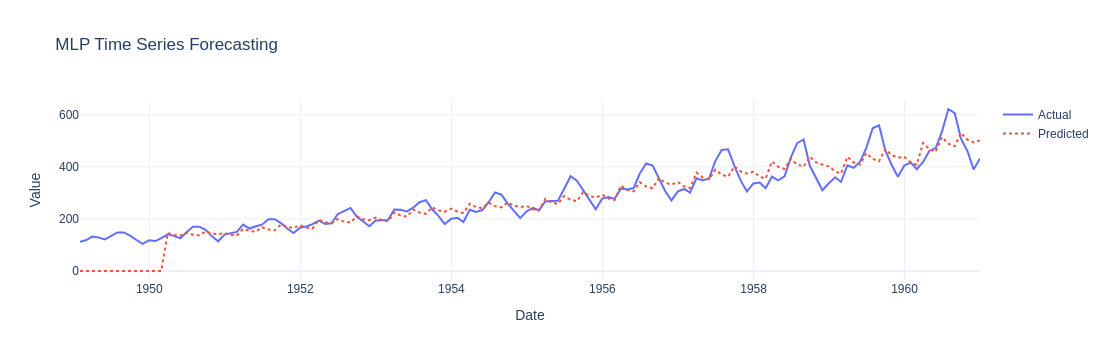

In [ ]:
import plotly.graph_objects as go
import torch

# Extract the target variable
x = df.y.values
model.eval()

# Initialize tensor for predictions
y_pred = torch.zeros(len(x))

# Perform iterative predictions
for idx in range(0, len(x) - in_features, window):
    x_input = torch.tensor(x[idx : idx + in_features], dtype=torch.float32).unsqueeze(
        0
    )  # Add batch dimension
    y_out = model(x_input).squeeze().detach()  # Run model & remove unnecessary dimensions

    # Ensure output fits within bounds
    end_idx = min(idx + in_features + out_features, len(y_pred))
    y_pred[idx + in_features : end_idx] = y_out[
        : end_idx - (idx + in_features)
    ]  # Assign predictions carefully

# Convert to NumPy for Plotly
x_values = df.ds.values  # Assuming 'ds' is the date column
y_actual = x  # Original values
y_pred = y_pred.numpy()

# Plotly visualization
fig = go.Figure()
fig.add_trace(go.Scatter(x=x_values, y=y_actual, mode="lines", name="Actual"))
fig.add_trace(
    go.Scatter(x=x_values, y=y_pred, mode="lines", name="Predicted", line=dict(dash="dot"))
)

fig.update_layout(
    title="MLP Time Series Forecasting",
    xaxis_title="Date",
    yaxis_title="Value",
    template="plotly_white",
)
fig.show()

In [ ]:
## Single model for all ts
from datasetsforecast.m3 import M3

M3.download("data/")
df = M3.load("data/", group="Monthly")[0]
df.head()

/home/pranav-pc/.cache/pypoetry/virtualenvs/ts-EBaOKu-T-py3.12/lib/python3.12/site-packages/datasetsforecast/m3.py:108: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,unique_id,ds,y
0,M1,1990-01-31,2640.0
1,M1,1990-02-28,2640.0
2,M1,1990-03-31,2160.0
3,M1,1990-04-30,4200.0
4,M1,1990-05-31,3360.0


In [ ]:
in_features, out_features, window, batch_sz = 12, 6, 2, 2048 * 6
layers = 3
hidden_sz = 32

In [ ]:
ds = TSDataLoader(df, in_features, out_features, window, batch_sz)
model = MLP(in_features, layers, hidden_sz, out_features).to(device)
trainer = pl.Trainer(max_epochs=30, val_check_interval=2, logger=None)
trainer.fit(model, ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 3.8 K  | train
1 | loss  | HuberLoss  | 0      | train
---------------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
trainer.validate(model, ds);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             714.2485961914062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
trainer.test(model, ds);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           207.65223693847656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


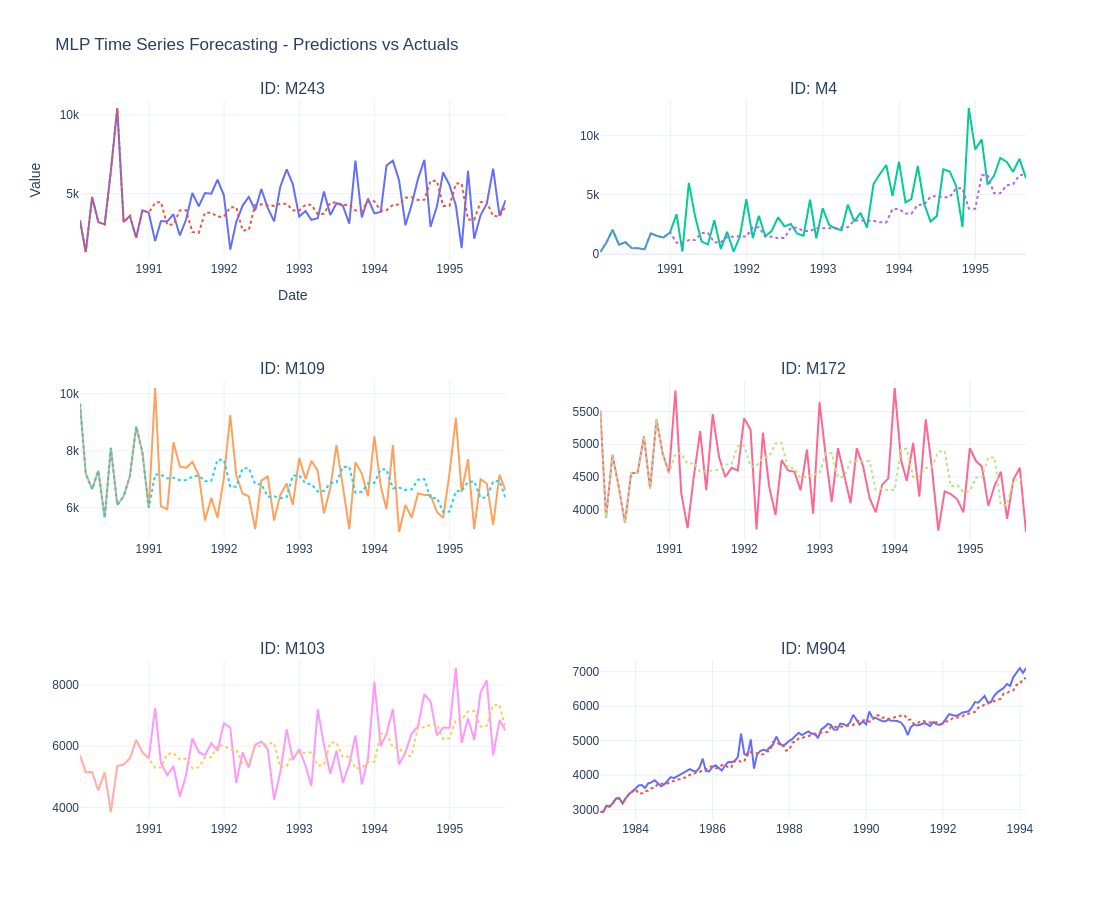

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
from plotly.subplots import make_subplots

# Select 6 random unique_ids
unique_ids = df["unique_id"].unique()
selected_ids = np.random.choice(unique_ids, 6, replace=False)

# Create 3x2 subplot layout
fig = make_subplots(rows=3, cols=2, subplot_titles=[f"ID: {uid}" for uid in selected_ids])

# Process each unique_id separately
model.eval()

for i, uid in enumerate(selected_ids):
    row, col = divmod(i, 2)  # Convert index to subplot grid position (row, col)

    # Filter DataFrame for the specific unique_id
    subset_df = df[df["unique_id"] == uid].copy()
    x_values = subset_df["ds"].values  # Dates
    x = subset_df["y"].values  # Target values

    # Initialize prediction tensor
    y_pred = torch.zeros(len(x))
    y_pred[:in_features] = torch.tensor(x[:in_features].tolist())

    # Perform iterative predictions
    for idx in range(0, len(x) - in_features, window):
        x_input = torch.tensor(x[idx : idx + in_features], dtype=torch.float32).unsqueeze(
            0
        )  # Add batch dimension
        y_out = model(x_input).squeeze().detach()  # Run model & remove unnecessary dimensions

        # Ensure output fits within bounds
        end_idx = min(idx + in_features + out_features, len(y_pred))
        y_pred[idx + in_features : end_idx] = y_out[
            : end_idx - (idx + in_features)
        ]  # Assign predictions carefully

    # Convert predictions to NumPy
    y_pred = y_pred.numpy()

    # Add traces to subplot
    fig.add_trace(
        go.Scatter(x=x_values, y=x, mode="lines", name=f"Actual {uid}"), row=row + 1, col=col + 1
    )
    fig.add_trace(
        go.Scatter(
            x=x_values, y=y_pred, mode="lines", name=f"Predicted {uid}", line=dict(dash="dot")
        ),
        row=row + 1,
        col=col + 1,
    )

# Update layout
fig.update_layout(
    title="MLP Time Series Forecasting - Predictions vs Actuals",
    xaxis_title="Date",
    yaxis_title="Value",
    template="plotly_white",
    height=900,
    width=1200,
    showlegend=False,
)

fig.show()